In [1]:
import os
import PIL.Image as Image
import torch.cuda
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from LookGenerator.networks.clothes_feature_extractor import ClothingAutoEncoder
from LookGenerator.datasets.basic_dataset import BasicDataset
from LookGenerator.networks.losses import VAELoss
from LookGenerator.networks.utils import load_model
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from torchsummary import summary
from LookGenerator.networks.utils import get_num_digits, save_model
from LookGenerator.networks_training.utils import check_path_and_creat

In [2]:
transform_input = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [3]:
batch_size_train = 32
batch_size_val = 16
pin_memory = True
num_workers = 4

In [4]:
train_dataset = BasicDataset(
    root_dir=r"C:\Users\DenisovDmitrii\Desktop\zalando-hd-resize\train",
    dir_name=r"cloth",
    transform_input=transform_input
)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=pin_memory,
    num_workers=num_workers
)

In [5]:
val_dataset = BasicDataset(
    root_dir=r"C:\Users\DenisovDmitrii\Desktop\zalando-hd-resize\test",
    dir_name="cloth",
    transform_input=transform_input
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size_train, shuffle=False, pin_memory=pin_memory,
    num_workers=num_workers
)

In [6]:
print(len(val_dataset), len(val_dataloader))
print(len(train_dataset), len(train_dataloader))

2032 64
11647 364


In [7]:
def _epoch_string(epoch, epoch_num):
    num_digits_epoch_num = get_num_digits(epoch_num)
    num_digits_epoch = get_num_digits(epoch)

    epoch_string = "0"*(num_digits_epoch_num - num_digits_epoch) + str(epoch)
    return epoch_string

In [8]:
def fit(model, criterion, optimizer, device, train_loader, val_loader, epochs, save_directory, save_step=1):

    train_loss=[]
    val_loss=[]

    criterion = criterion.to(device)
    model = model.to(device)

    for epoch in range(epochs):
        torch.cuda.empty_cache()
        model.to(device)
        model.train()

        train_epoch_loss = []
        for X_batch in tqdm(train_loader):
            X_batch = X_batch.to(device)
            optimizer.zero_grad()
            pred = model(X_batch)
            reconstructed, mu, log_var = pred
            loss = criterion(X_batch, mu, log_var, reconstructed)
            loss.backward()
            optimizer.step()
            # print(mu, log_var)
            train_epoch_loss.append(loss.item())
            # print(loss.item())
        train_loss.append(np.mean(train_epoch_loss))

        model.eval()
        val_loss_epoch = []
        with torch.no_grad():
          for X_val in tqdm(val_loader):
              X_val = X_val.to(device)
              pred = model(X_val)
              reconstructed, mu, log_var  = pred
              loss = criterion(X_val, mu, log_var, reconstructed)
              val_loss_epoch.append(loss.item())
        val_loss.append(np.mean(val_loss_epoch))

        print("Epoch [{}/{}], train_loss: {:.3f}, val_loss: {:.3f}".format(
            epoch+1, epochs,
            train_loss[-1], val_loss[-1])
        )

        if (epoch + 1) % save_step == 0:
            save_model(
            model.to('cpu'),
            path=f"{save_directory}\\epoch_{_epoch_string(epoch, epochs)}.pt"
        )

    return train_loss, val_loss

In [9]:
save_directory=r"C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\autoDegradation\weights\session1"
check_path_and_creat(save_directory)

True

In [10]:
criterion = VAELoss()
model = ClothingAutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr = 10e-5)
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
train_loss, val_loss = fit(model=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           train_loader=train_dataloader,
                           val_loader=val_dataloader,
                           epochs=30,
                           save_directory=save_directory,
                           device=device)

100%|██████████| 64/64 [00:11<00:00,  5.45it/s]


Epoch [1/30], train_loss: 1.735, val_loss: 0.589


100%|██████████| 64/64 [00:10<00:00,  5.89it/s]


Epoch [2/30], train_loss: 0.384, val_loss: 0.515


100%|██████████| 64/64 [00:10<00:00,  6.12it/s]


Epoch [3/30], train_loss: 0.385, val_loss: 0.542


100%|██████████| 64/64 [00:10<00:00,  6.11it/s]


Epoch [4/30], train_loss: 0.409, val_loss: 0.493


100%|██████████| 64/64 [00:10<00:00,  6.19it/s]


Epoch [5/30], train_loss: 0.364, val_loss: 0.822


100%|██████████| 64/64 [00:10<00:00,  5.87it/s]


Epoch [6/30], train_loss: 3.255, val_loss: 0.472


100%|██████████| 64/64 [00:10<00:00,  6.04it/s]


Epoch [7/30], train_loss: 0.364, val_loss: 0.472


100%|██████████| 64/64 [00:11<00:00,  5.64it/s]


Epoch [8/30], train_loss: 0.342, val_loss: 0.452


100%|██████████| 64/64 [00:10<00:00,  5.88it/s]


Epoch [9/30], train_loss: 0.339, val_loss: 0.460


100%|██████████| 64/64 [00:10<00:00,  5.95it/s]


Epoch [10/30], train_loss: 0.340, val_loss: 0.458


100%|██████████| 64/64 [00:10<00:00,  6.00it/s]


Epoch [11/30], train_loss: 0.401, val_loss: 0.566


100%|██████████| 64/64 [00:11<00:00,  5.72it/s]


Epoch [12/30], train_loss: 4.659, val_loss: 0.711


100%|██████████| 64/64 [00:10<00:00,  6.24it/s]


Epoch [13/30], train_loss: 0.437, val_loss: 0.509


100%|██████████| 64/64 [00:10<00:00,  6.17it/s]


Epoch [14/30], train_loss: 0.362, val_loss: 0.489


100%|██████████| 64/64 [00:10<00:00,  6.06it/s]


Epoch [15/30], train_loss: 0.341, val_loss: 0.516


100%|██████████| 64/64 [00:10<00:00,  5.99it/s]


Epoch [16/30], train_loss: 0.530, val_loss: 1.695


100%|██████████| 64/64 [00:10<00:00,  6.06it/s]


Epoch [17/30], train_loss: 0.415, val_loss: 0.457


100%|██████████| 64/64 [00:10<00:00,  6.02it/s]


Epoch [18/30], train_loss: 0.357, val_loss: 0.480


100%|██████████| 64/64 [00:11<00:00,  5.82it/s]


Epoch [19/30], train_loss: 0.370, val_loss: 0.451


100%|██████████| 64/64 [00:11<00:00,  5.71it/s]


Epoch [20/30], train_loss: 0.425, val_loss: 0.516


100%|██████████| 64/64 [00:10<00:00,  5.95it/s]


Epoch [21/30], train_loss: 0.503, val_loss: 1.695


100%|██████████| 64/64 [00:10<00:00,  6.04it/s]


Epoch [22/30], train_loss: 0.411, val_loss: 0.499


100%|██████████| 64/64 [00:10<00:00,  6.11it/s]


Epoch [23/30], train_loss: 0.397, val_loss: 0.471


100%|██████████| 64/64 [00:10<00:00,  5.98it/s]


Epoch [24/30], train_loss: 4.691, val_loss: 1.140


100%|██████████| 64/64 [00:10<00:00,  6.12it/s]


Epoch [25/30], train_loss: 0.622, val_loss: 0.468


100%|██████████| 64/64 [00:10<00:00,  5.89it/s]


Epoch [26/30], train_loss: 0.348, val_loss: 0.463


100%|██████████| 64/64 [00:10<00:00,  6.17it/s]


Epoch [27/30], train_loss: 0.337, val_loss: 0.421


100%|██████████| 64/64 [00:10<00:00,  6.13it/s]


Epoch [28/30], train_loss: 0.330, val_loss: 0.450


100%|██████████| 64/64 [00:10<00:00,  6.16it/s]


Epoch [29/30], train_loss: 0.329, val_loss: 0.442


100%|██████████| 64/64 [00:10<00:00,  6.22it/s]

Epoch [30/30], train_loss: 0.333, val_loss: 0.408


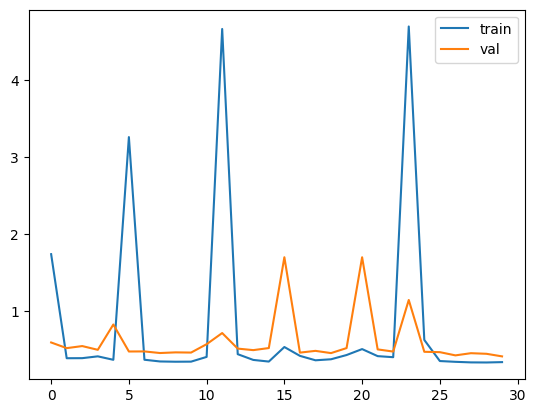

In [12]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.show()

In [16]:
model.eval()
model.to('cpu')
for X_val in val_dataloader:
  reconstructed, mu, log_var = model(X_val)
  img = transforms.ToPILImage()(reconstructed[0]/2+0.5)
  cl = transforms.ToPILImage()(X_val[0])
  cl.show()
  img.show()
  break